### Introduction : One of the Insurance company offering difference insurance products and one of the product is auto insurance for different vehicle.As part of lead management they are offering online Quotes based on specifications of vehicles , customer details.
### The data has been provided for last 40 months data on monthly basis

## Problem Statement : Forecast Quotes for next few months.

In [45]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats
%matplotlib inline
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
import statsmodels.api as sm
from statsmodels.tsa.arima_model import ARIMA
import statsmodels.api as sm
import statsmodels.tsa.holtwinters as ets
import statsmodels.tools.eval_measures as fa
from statsmodels.tsa.holtwinters import  SimpleExpSmoothing, Holt, ExponentialSmoothing
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error

In [2]:
# Import the csv file in pandas
Insurance=pd.read_csv('C://Users//hp//Downloads//Insurance (2).csv',parse_dates = ["Month"],index_col = 0)

In [3]:
Insurance.head() # Shows top 5 rows of data

,Quotes,TV.advert,Lag1,Lag2
Month,,,,
Jan-15,12.97065,7.212725,NaN,NaN
Feb-15,15.38714,9.443570,7.212725,NaN
Mar-15,13.22957,7.534250,9.443570,7.212725
Apr-15,12.97065,7.212725,7.534250,9.443570
May-15,15.38714,9.443570,7.212725,7.534250


In [4]:
Insurance.info()

<class 'pandas.core.frame.DataFrame'>
Index: 40 entries, Jan-15 to Apr-18
Data columns (total 4 columns):
Quotes       40 non-null float64
TV.advert    40 non-null float64
Lag1         39 non-null float64
Lag2         38 non-null float64
dtypes: float64(4)
memory usage: 1.6+ KB


In [5]:
Insurance.Quotes.mean()

13.604346999999999

In [6]:
Insurance.Quotes.max()

18.438979999999997

In [7]:
Insurance.Quotes.min()

8.394680000000001

In [8]:
Insurance.Quotes.median()

13.287435000000002

In [9]:
Insurance.isnull().sum()

Quotes       0
TV.advert    0
Lag1         1
Lag2         2
dtype: int64

In [10]:
## Filling Missing Value with Median.
Insurance.Lag1.fillna(value=Insurance.Lag1.median(),inplace=True)

In [11]:
Insurance.Lag2.fillna(value=Insurance.Lag2.median(),inplace=True)

In [12]:
Insurance.describe()

,Quotes,TV.advert,Lag1,Lag2
count,40.000000,40.000000,40.000000,40.000000
mean,13.604347,8.175403,8.158619,8.097466
std,2.399347,1.317264,1.314308,1.260453
min,8.394680,5.707495,5.707495,5.707495
25%,12.023205,7.212725,7.212725,7.212725
50%,13.287435,8.151056,8.057230,8.033715
75%,15.504800,9.262940,9.262940,9.022842
max,18.438980,10.963800,10.963800,10.963800


## Method1 :Regression on time

In [13]:
time = [i+1 for i in range(len(Insurance))]

In [14]:
Insurance['time'] = time
Insurance.head()

,Quotes,TV.advert,Lag1,Lag2,time
Month,,,,,
Jan-15,12.97065,7.212725,8.057230,8.033715,1
Feb-15,15.38714,9.443570,7.212725,8.033715,2
Mar-15,13.22957,7.534250,9.443570,7.212725,3
Apr-15,12.97065,7.212725,7.534250,9.443570,4
May-15,15.38714,9.443570,7.212725,7.534250,5


In [15]:
train=Insurance[0:int(len(Insurance)*0.7)] 
test=Insurance[int(len(Insurance)*0.7):]

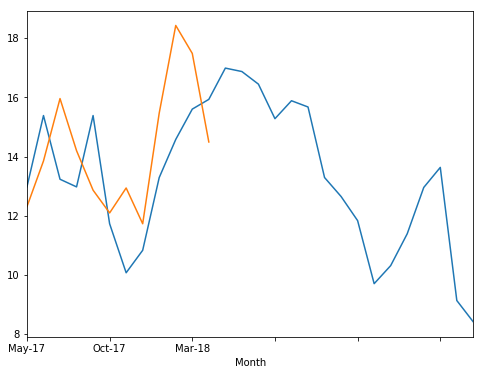

In [16]:
train.Quotes.plot(figsize=[8,6])
test.Quotes.plot(figsize=[8,6])

In [17]:
quotes_ts = Insurance['Quotes']
result = adfuller(quotes_ts)

In [18]:
print(result)

(-3.423136105073109, 0.010194998749727959, 1, 38, {'1%': -3.6155091011809297, '5%': -2.941262357486514, '10%': -2.6091995013850418}, 115.51427465496377)


### here adf statistic is =  -3.423 and p value = 0.010 which means it is stationary if adf statistic = less than 0.5 and p value less than 0.05 then series is stationary.

## This series is stationary 
###  A stationary time series is one whose statistical properties such as mean, variance, autocorrelation, etc. are all constant over time.

### So, we have to decompose to understand long term effect or to understand the relative effect.Decomposition provides a useful abstract model for thinking about time series generally and for better understanding problems during time series analysis and forecasting.

##  Decompostion of time series :ADDITIVE and MULTIPLICATIVE MODEL

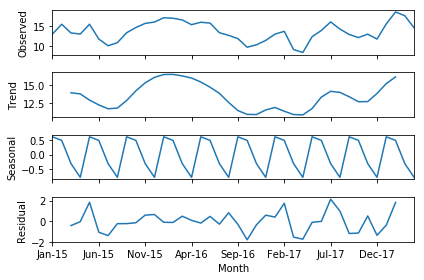

In [19]:
#use decomposition to identify the trend and seasonality components
# Additive model freq set to 4 because We want in quarters  data 
# obs = level + trend + seasonality + error (residual = whitenoise)

decompInsurance = seasonal_decompose(Insurance.Quotes, model="additive", freq=4)
decompInsurance.plot()
plt.show()

In [20]:
#Extract the trend , seasonality and random components
trend = decompInsurance.trend
seasonal = decompInsurance.seasonal
residual = decompInsurance.resid

In [21]:
print(trend.head())
print(seasonal.head())
print(residual.head())

Month
Jan-15          NaN
Feb-15          NaN
Mar-15    13.941564
Apr-15    13.785592
May-15    12.931585
Name: Quotes, dtype: float64
Month
Jan-15    0.617829
Feb-15    0.491592
Mar-15   -0.315839
Apr-15   -0.793582
May-15    0.617829
Name: Quotes, dtype: float64
Month
Jan-15         NaN
Feb-15         NaN
Mar-15   -0.396154
Apr-15   -0.021360
May-15    1.837726
Name: Quotes, dtype: float64


# determining the autocorrelation factor

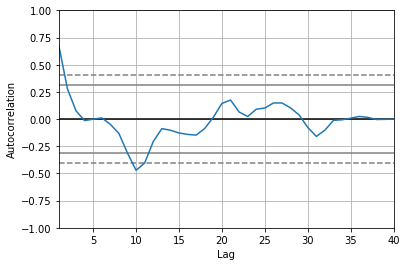

In [22]:
pd.plotting.autocorrelation_plot(Insurance['Quotes'])

In [23]:
Insurance.Quotes.corr(Insurance.Quotes.shift(4))

-0.01580646616527665

In [24]:
Insurance['stationary']=Insurance['Quotes'].diff()

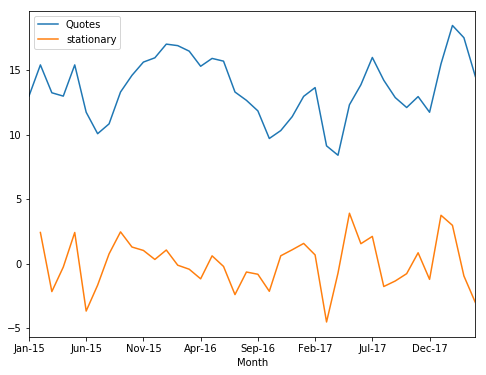

In [25]:
Insurance[["Quotes","stationary"]].plot(figsize=(8,6))

In [26]:
# parameter - p,q,d
# p - periods taken for auto regressive model - how many month ? 1 month then 1 period
# q - moving average, get the errors.Perios in moving average
# d - order of integreation or integrated order - how many times difference is done
model_arima = ARIMA(train["Quotes"],order = (3,1,0)) # p =3 , d = 1, q =1
model_arima_fit = model_arima.fit()
print(model_arima_fit.aic)

C:\Users\hp\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:221: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
C:\Users\hp\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:221: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


113.86484305480124


In [27]:
predictions = model_arima_fit.forecast(steps=12)[0]
predictions

array([9.83852077, 9.44605964, 8.65893575, 8.78039437, 8.86703729,
       8.57843619, 8.39440006, 8.34607182, 8.22133759, 8.05682618,
       7.93427059, 7.81878353])

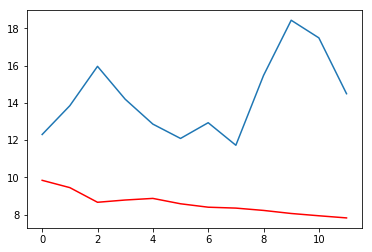

In [28]:
plt.plot(test["Quotes"].values)
plt.plot(predictions,color = 'red')

In [29]:
test["Quotes"].values

array([12.30076, 13.84831, 15.96246, 14.19738, 12.85922, 12.08837,
       12.93375, 11.72235, 15.47126, 18.43898, 17.49186, 14.49168])

In [30]:
p=d=q=range(0,5)
import itertools
## create a list with all possible combination
pdq = list(itertools.product(p,d,q))
pdq

[(0, 0, 0),
 (0, 0, 1),
 (0, 0, 2),
 (0, 0, 3),
 (0, 0, 4),
 (0, 1, 0),
 (0, 1, 1),
 (0, 1, 2),
 (0, 1, 3),
 (0, 1, 4),
 (0, 2, 0),
 (0, 2, 1),
 (0, 2, 2),
 (0, 2, 3),
 (0, 2, 4),
 (0, 3, 0),
 (0, 3, 1),
 (0, 3, 2),
 (0, 3, 3),
 (0, 3, 4),
 (0, 4, 0),
 (0, 4, 1),
 (0, 4, 2),
 (0, 4, 3),
 (0, 4, 4),
 (1, 0, 0),
 (1, 0, 1),
 (1, 0, 2),
 (1, 0, 3),
 (1, 0, 4),
 (1, 1, 0),
 (1, 1, 1),
 (1, 1, 2),
 (1, 1, 3),
 (1, 1, 4),
 (1, 2, 0),
 (1, 2, 1),
 (1, 2, 2),
 (1, 2, 3),
 (1, 2, 4),
 (1, 3, 0),
 (1, 3, 1),
 (1, 3, 2),
 (1, 3, 3),
 (1, 3, 4),
 (1, 4, 0),
 (1, 4, 1),
 (1, 4, 2),
 (1, 4, 3),
 (1, 4, 4),
 (2, 0, 0),
 (2, 0, 1),
 (2, 0, 2),
 (2, 0, 3),
 (2, 0, 4),
 (2, 1, 0),
 (2, 1, 1),
 (2, 1, 2),
 (2, 1, 3),
 (2, 1, 4),
 (2, 2, 0),
 (2, 2, 1),
 (2, 2, 2),
 (2, 2, 3),
 (2, 2, 4),
 (2, 3, 0),
 (2, 3, 1),
 (2, 3, 2),
 (2, 3, 3),
 (2, 3, 4),
 (2, 4, 0),
 (2, 4, 1),
 (2, 4, 2),
 (2, 4, 3),
 (2, 4, 4),
 (3, 0, 0),
 (3, 0, 1),
 (3, 0, 2),
 (3, 0, 3),
 (3, 0, 4),
 (3, 1, 0),
 (3, 1, 1),
 (3, 1, 2),
 (3,

In [31]:
import warnings 
warnings.filterwarnings('ignore')

for param in pdq:
    try:
        model_arima = ARIMA(train["Quotes"],order = param)
        model_arima_fit = model_arima.fit()
        print(param,model_arima_fit.aic)
    
    except:
        continue

(0, 0, 0) 133.06227132518654
(0, 0, 1) 115.23357888047727
(0, 1, 0) 110.31129307085867
(0, 1, 1) 112.24161663359365
(0, 1, 2) 110.91202157768777
(0, 1, 3) 112.91064413298423
(0, 1, 4) 114.84500809318835
(0, 2, 0) 123.17730452585994
(0, 2, 1) 111.57859087518284
(0, 2, 2) 113.44019517993698
(1, 0, 0) 114.14696064022314
(1, 0, 1) 113.37064248477952
(1, 0, 2) 114.80589761560002
(1, 0, 4) 115.79691759946233
(1, 1, 0) 112.27515152345455
(1, 2, 0) 121.55400958252346
(2, 0, 0) 114.97611232886219
(2, 0, 1) 114.84997232657582
(2, 0, 2) 116.75106842812968
(2, 1, 0) 112.26856867344284
(2, 1, 1) 113.02642290337647
(2, 2, 0) 116.42742489455918
(2, 2, 1) 113.9143551430811
(2, 2, 2) 114.70785457609573
(3, 0, 0) 116.12684319267264
(3, 0, 1) 116.59729121236853
(3, 0, 2) 119.1151800341703
(3, 1, 0) 113.86484305480124
(3, 1, 1) 115.01581418000697
(3, 1, 2) 116.70046726266645
(3, 2, 0) 118.30683136852662
(3, 2, 1) 120.3300492233199
(3, 2, 2) 117.09748661278914
(4, 0, 0) 116.68150424907694
(4, 0, 1) 118.185

## Method1 :Regression on time

In [32]:
x_train = train.drop('Quotes', axis=1)
x_test = test.drop('Quotes', axis=1)
y_train = train[['Quotes']]
y_test = test[['Quotes']]

In [33]:
model = LinearRegression()

In [34]:
model.fit(x_train, y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None,
         normalize=False)

In [35]:
predictions = model.fit(x_train,y_train).predict(x_test)

In [36]:
y_test['Regontime'] = predictions

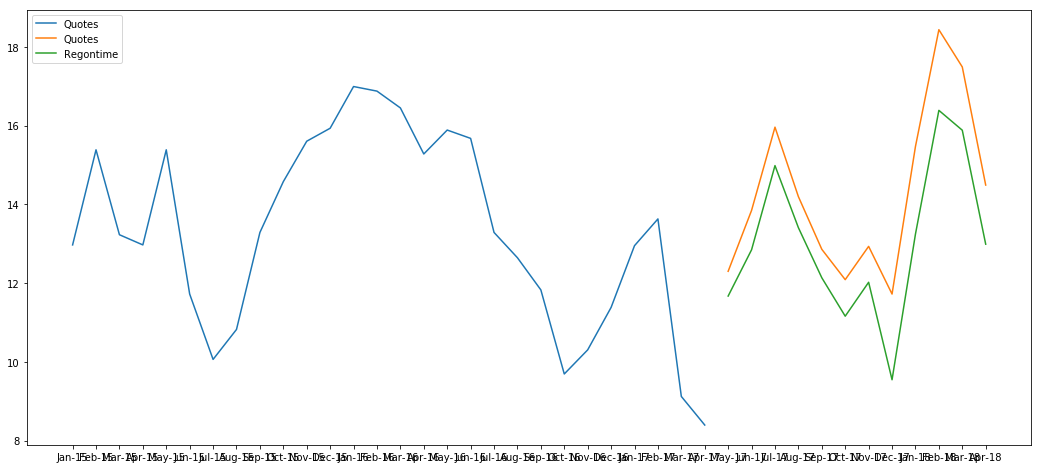

In [49]:
plt.figure(figsize=(18,8))
plt.plot(train['Quotes'])
plt.plot(test['Quotes'])
plt.plot(y_test['Regontime'])
plt.legend(loc='best')

In [46]:
rmse = np.sqrt(mean_squared_error(test.Quotes,predictions))
rmse = round(rmse, 3)
rmse

1.412

In [51]:
mape = np.mean(np.abs((test['Quotes']-y_test['Regontime'])/test['Quotes']))
mape = round(mape,3)
mape

0.09

In [52]:
ResultsDf = pd.DataFrame({'Method':['RegressionOnTime'], 'MAPE': [mape], 'RMSE': [rmse]})
ResultsDf

,Method,MAPE,RMSE
0,RegressionOnTime,0.09,1.412
